In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-06-21 09:14:23,713 [info] loaded project stocks from MLRun DB


In [2]:
# from mlrun.runtimes import Spark3Runtime
# Spark3Runtime.deploy_default_image()

In [3]:
# mlrun: start-code
from mlrun.feature_store.api import ingest
from IPython.display import display


def ingest_handler(context):
    ingest(mlrun_context=context) # The handler function must call ingest with the mlrun_context

# You can add your own PySpark code as a graph step:
def filter_func(df, context=None):
    return df.filter("bid>55") # PySpark code


def add_column(df, context=None):
    return_df = df.withColumn("bid_ask_diff", df.bid-df.ask)
    return return_df

def print_dataframe(df, contest=None):
    print("type of data frame {}".format(type(df)))        
    print(df.show())
    return df

# mlrun: end-code

In [24]:
import os

print(os.getcwd())

def get_stocks_file(directory):        
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if f.endswith('StocksGenerator.csv'):                                                
                path = f.replace("/v3io","v3io://")
                print(path)
                return path            


/User/aviaIguazio/demos/stock-analysis


In [26]:
from mlrun.datastore.sources import CSVSource
from mlrun import code_to_function
import mlrun.feature_store as fstore

feature_set = fstore.FeatureSet("stocks", entities=[fstore.Entity("ticker")],timestamp_key='Datetime', engine="spark")

#source = CSVSource("mycsv", path="v3io:///users/aviaIguazio/demos/stock-analysis/data/20220621-084843-StocksGenerator.csv")
source_path = get_stocks_file('/v3io/projects/data')            
source = CSVSource("mycsv", path=source_path)

feature_set.graph\
    .to(name="print_dataframe", handler="print_dataframe")


v3io:///projects/data/20220621-092056-StocksGenerator.csv


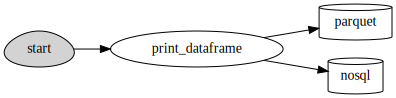

In [27]:
    
# Setting default targets (nosql & parquet)
feature_set.set_targets(with_defaults=True) 
feature_set.plot(rankdir="LR", with_targets=True)

In [ ]:
my_func = code_to_function("func", kind="spark")

my_func.with_driver_requests(cpu=1, mem="1G")
my_func.with_executor_requests(cpu=1, mem="1G")
my_func.with_igz_spark()

# Enables using the default image (can be replace with specifying a specific image with .spec.image)
my_func.spec.use_default_image = True

# Not a must - default: 1
my_func.spec.replicas = 2

# If needed, sparkConf can be modified like this:
# my_func.spec.spark_conf['spark.specific.config.key'] = 'value'

config = fstore.RunConfig(local=False, function=my_func, handler="ingest_handler")
quotes_df = fstore.ingest(feature_set, source, run_config=config)

> 2022-06-21 09:24:33,196 [info] starting run stocks-ingest uid=09c3192402494efdbaeac9af8707ff18 DB=http://mlrun-api:8080
++ id -u
+ myuid=1000
++ id -g
+ mygid=1000
+ set +e
++ getent passwd 1000
+ uidentry=iguazio:x:1000:1000::/igz:/bin/bash
+ set -e
+ '[' -z iguazio:x:1000:1000::/igz:/bin/bash ']'
+ SPARK_CLASSPATH=':/spark/jars/*'
+ env
+ grep SPARK_JAVA_OPT_
+ sort -t_ -k4 -n
+ sed 's/[^=]*=\(.*\)/\1/g'
+ readarray -t SPARK_EXECUTOR_JAVA_OPTS
+ '[' -n '' ']'
+ '[' -z ']'
+ '[' -z ']'
+ '[' -n /hadoop ']'
+ '[' -z '' ']'
++ /hadoop/bin/hadoop classpath
+ export 'SPARK_DIST_CLASSPATH=/hadoop/etc/hadoop:/hadoop/share/hadoop/common/lib/*:/hadoop/share/hadoop/common/*:/hadoop/share/hadoop/hdfs:/hadoop/share/hadoop/hdfs/lib/*:/hadoop/share/hadoop/hdfs/*:/hadoop/share/hadoop/mapreduce/lib/*:/hadoop/share/hadoop/mapreduce/*:/hadoop/share/hadoop/yarn:/hadoop/share/hadoop/yarn/lib/*:/hadoop/share/hadoop/yarn/*:/hadoop/share/hadoop/tools/lib/hadoop-aws-3.2.0.jar:/hadoop/share/hadoop/tools/li

In [ ]:
features = [
    "stocks.*",
]

vector = fstore.FeatureVector("stocks-vec",features=features,description="this is my vector",with_indexes=True)
resp = fstore.get_offline_features(vector)

In [ ]:
df = resp.to_dataframe()

In [ ]:
df